In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import json
import time
import logging

import implicit
from implicit import bpr, als, nearest_neighbours, approximate_als

from scipy.sparse import coo_matrix, csr_matrix, save_npz, load_npz

logger = logging.getLogger()
fhandler = logging.FileHandler(filename='mylog.log', mode='a')
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)
logger.setLevel(logging.DEBUG)

# Load Data

In [2]:
DATA_FOLDER = "../input"
TMP_FOLDER = os.path.join(DATA_FOLDER, "tmp")
EXPLICIT_FOLDER = os.path.join(TMP_FOLDER, 'explicit_newuser')

train_matrix_file_name = 'train_matrix.npz'
test_csv_file_name = 'test_interactions.csv'
train_csv_file_name = 'train_interactions.csv'
metadata_file_name = 'metadata.json'

In [3]:
train_matrix = load_npz(os.path.join(EXPLICIT_FOLDER, train_matrix_file_name))
test_df = pd.read_csv(os.path.join(EXPLICIT_FOLDER, test_csv_file_name), dtype=str)
train_df = pd.read_csv(os.path.join(EXPLICIT_FOLDER, train_csv_file_name), dtype=str)
with open(os.path.join(EXPLICIT_FOLDER, metadata_file_name), 'r') as fp:
    metadata = json.load(fp)

# Train and Validate Model

In [4]:
def top_k_accuracy(ground_series, rec_dict, k):
    if k == 0:
        return 0
    
    acc = 0
    count = 0
    for user_id in test_user_item_index.index.levels[0]:
        top_k_rec = rec_dict[user_id][0:min(k, len(rec_dict[user_id]))]
        if ground_series[user_id].shape[0] == 0:
            continue
        
        # number of intersetion items
        num_match = ground_series[user_id].isin(top_k_rec).map(lambda ele: 1.0 if ele else 0.0).sum()
        
        acc += num_match / min(len(top_k_rec), ground_series[user_id].shape[0])
        
        count += 1
        
    acc /= count
    
    return acc

def top_k_accuracy_bins(ground_series, rec_dict, k, train_series, bins=5):
    if k == 0:
        return 0
    
    acc = dict()
    count = dict()
    for user_id in rec_dict.keys():
        top_k_rec = rec_dict[user_id][0:min(k, len(rec_dict[user_id]))]
        if ground_series[user_id].shape[0] == 0:
            continue
        
        if isinstance(bins, list):
            bin_index = bs(bins, train_series[user_id].shape[0])
        else:
            bin_index = (train_series[user_id].shape[0] // bins) * bins
            
        # number of intersetion items
        num_match = ground_series[user_id].isin(top_k_rec).map(lambda ele: 1.0 if ele else 0.0).sum()
        
        if bin_index not in acc:
            acc[bin_index] = 0.0
            count[bin_index] = 0
        acc[bin_index] += (num_match / min(len(top_k_rec), ground_series[user_id].shape[0])) if len(top_k_rec) > 0 else 0
        count[bin_index] += 1
    
    print("mean top k accuracy: " + str(np.asarray(list(acc.values())).sum() / np.asarray(list(count.values())).sum()))
    
    for bin_index in acc.keys():
        acc[bin_index] /= count[bin_index]
    
    return pd.Series(acc, index=sorted(list(acc.keys())))

def bs(a, target):
    if target > a[-1]:
        return len(a)

    lo, hi = 0, len(a)-1
    
    while lo < hi:
        mid = lo + int((hi - 1) / 2)
        if target < a[mid]:
            hi = mid
        elif target > a[mid]:
            lo = mid + 1
        else:
            return mid
        
    return lo

In [5]:
test_user_item = test_df.groupby('USER_ID').apply(lambda group: group['ITEM_ID'])
test_user_item_index = test_user_item.map(lambda ele: metadata['item_index'][ele])

In [6]:
train_user_item = train_df.groupby('USER_ID').apply(lambda group: group['ITEM_ID'])
train_user_item_index = train_user_item.map(lambda ele: metadata['item_index'][ele])

In [7]:
test_user_item_index.index.levels[0]

Index(['000005bb-44fb-469e-8c22-bc8979b6e11d',
       '00014a37-91ac-4453-8c27-87df46a9959f',
       '000186cc-93aa-4668-9e56-242944ec03c5',
       '0001ded5-708a-4ab6-ba0c-1d9084a968a9',
       '000204c2-e3e5-4d61-8289-aec22d2066bf',
       '00020be0-4ea8-4568-a9f3-bba0ba8bc1ea',
       '00021c2c-0a45-4362-b0fd-482db3186b6e',
       '00023648-c098-4f90-bcea-b5b4ac353afa',
       '000246d5-530e-4f3e-b4e7-81de4369aad4',
       '00025567-45f1-4f60-8578-a6eda8643d04',
       ...
       '2665379b-cf53-4a0f-bcce-6d4491568fc2',
       '266562cb-7c6a-440b-a023-2d5512ad0e2a',
       '26658082-0ec5-4c28-a86a-a75e84cc6c54',
       '26658d7b-6d93-4803-97a2-b5358224e928',
       '26659978-1ca3-4711-a937-c435f09dd29e',
       '2665b0dc-e6e8-40bc-95a9-a448bb09be59',
       '2665c601-8569-4c89-8977-7c495a7b4d37',
       '2665e24f-f268-4879-ae79-989a3bc72af1',
       '2665ff65-6184-436d-942a-3da2ea211946',
       '26662878-f7b0-4531-822a-dc8f14a3383e'],
      dtype='object', name='USER_ID', length=541

# COS

### Training

In [8]:
model_name = "cos"

In [9]:
model = nearest_neighbours.CosineRecommender(K=100)

In [10]:
start = time.time()
model.fit(train_matrix)
print("trained model '%s' in %s", model_name, time.time() - start)

100%|██████████| 224858/224858 [00:05<00:00, 44183.59it/s]


trained model '%s' in %s cos 6.8208818435668945


### Testing

In [11]:
rec_train_user_item_index = dict()
for user_id in train_user_item_index.index.levels[0]:
    rec_res = model.recommend(metadata['user_index'][user_id], train_matrix)
    rec_res = [ele[0] for ele in rec_res]
    rec_train_user_item_index[user_id] = rec_res
topkbins = top_k_accuracy_bins(train_user_item_index, rec_train_user_item_index, 10, train_user_item_index, bins=30)

mean top k accuracy: 0.0005015988032991615


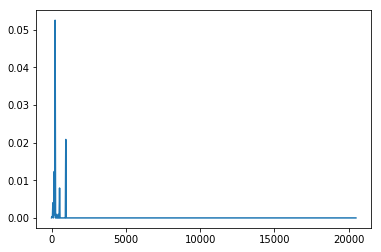

In [12]:
topkbins.plot(kind='line')

In [19]:
rec_test_user_item_index = dict()
for user_id in test_user_item_index.index.levels[0]:
    rec_res = model.recommend(metadata['user_index'][user_id], train_matrix, N=10, filter_items=train_user_item_index[user_id].values.tolist())
    rec_res = [ele[0] for ele in rec_res]
    rec_test_user_item_index[user_id] = rec_res
topkbins = top_k_accuracy_bins(test_user_item_index, rec_test_user_item_index, 10, train_user_item_index, bins=1)

mean top k accuracy: 3.0784954776901432e-06


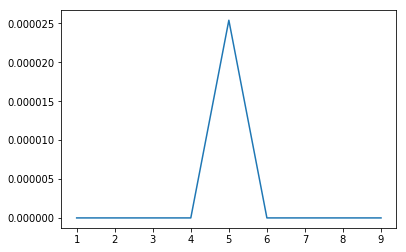

In [20]:
topkbins.plot(kind='line')

## TFIDF

### Training

In [21]:
model_name = "tfidf"

In [22]:
model = nearest_neighbours.TFIDFRecommender(K=100)

In [23]:
start = time.time()
model.fit(train_matrix)
print("trained model '%s' in %s", model_name, time.time() - start)

100%|██████████| 224858/224858 [00:04<00:00, 45291.16it/s]


trained model '%s' in %s tfidf 6.7647271156311035


### Testing

In [24]:
rec_train_user_item_index = dict()
for user_id in train_user_item_index.index.levels[0]:
    rec_res = model.recommend(metadata['user_index'][user_id], train_matrix, N=10)
    rec_res = [ele[0] for ele in rec_res]
    rec_train_user_item_index[user_id] = rec_res
topkbins = top_k_accuracy_bins(train_user_item_index, rec_train_user_item_index, 10, train_user_item_index, bins=1)

mean top k accuracy: 0.00045013517778967166


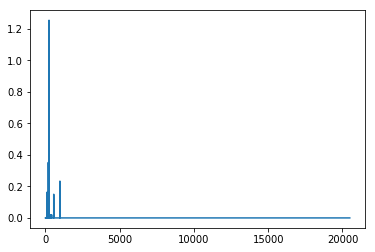

In [25]:
topkbins.plot(kind='line')

In [26]:
rec_test_user_item_index = dict()
for user_id in test_user_item_index.index.levels[0]:
    rec_res = model.recommend(metadata['user_index'][user_id], train_matrix, N=10, filter_items=train_user_item_index[user_id].values.tolist())
    rec_res = [ele[0] for ele in rec_res]
    rec_test_user_item_index[user_id] = rec_res
topkbins = top_k_accuracy_bins(test_user_item_index, rec_test_user_item_index, 10, train_user_item_index, bins=1)

mean top k accuracy: 3.0784954776901432e-06


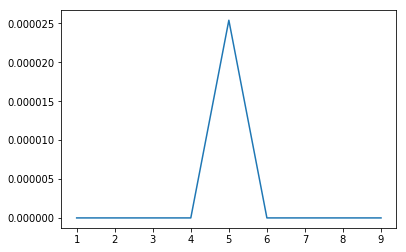

In [27]:
topkbins.plot(kind='line')